In [1]:
!pip install datasets

In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

<ipython-input-2-15a41e0e2f18>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


현재 허브에는 138507개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
# 개별 샘플 확인
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [10]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 로컬,원격 데이터를 불러올 때

*   load_datasest("csv", data_files="경로/파일이름.csv")
*   load_datasest("json", data_files="경로/파일이름.json")
*   load_datasest("text", data_files="경로/파일이름.txt")


---
dataset_url = "경로(사이트)/파일이름.txt:
!wget {dataset_url}

!head -n 1 train.txt
> i didnt feel humiliated;sadness

emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])






In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [81]:
# label int -> str
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


### 클래스 분포 확인

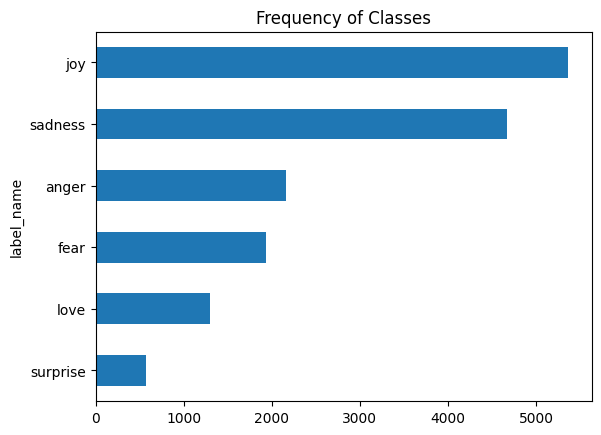

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()



*   불균형이 심함
*   joy와 sadness클래스가 많고 크게는 5배 정도 차이가 남
*   훈련/테스트 분할 후 훈련 데이터세트에만 샘플링 전략을 적용해 볼 수 있음



### 트윗 길이 확인: 최대 입력 시퀀스 길이

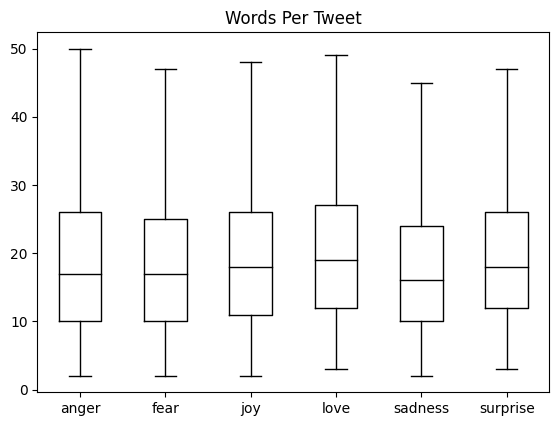

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()



*   각 감정 당 트윗의 길이는 15개 단어 정도이다.
*   이 경우는 모델의 문맥 크기(512)보다 작으므로 잘라내지 않고 사용한다.



In [15]:
# 원시 텍스트를 트랜스포머에 적합한 포맷으로 변환
# 데이터셋의 출력 포맷을 초기화
emotions.reset_format()

### 문자 토큰화

In [16]:
text = "Tokenizing text is a core task of NLP"
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [17]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [18]:
# 각 토큰을 고유한 숫자 식별자로 매핑
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [19]:
categorical_df = pd.DataFrame({"Name":["Rose", "dandelion", "lilac"], "Label ID":[0, 1, 2]})
categorical_df

,Name,Label ID
0,Rose,0
1,dandelion,1
2,lilac,2


In [20]:
pd.get_dummies(categorical_df["Name"]) # 원핫인코딩

,Rose,dandelion,lilac
0,True,False,False
1,False,True,False
2,False,False,True


In [21]:
# torch로 input_ids를 텐서로 바꾸고 원핫인코딩
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])



*   one_hot()에 num_classes를 지정하는 것이 중요하다. 지정하지 않으면 원핫벡터가 어휘사전 길이보다 더 짧아진다.
*   tf.one_hout()에서는 depth를 지정해주기.



In [22]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 4
원-핫 인코딩: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])





*    위와 같이 문자 토큰화는 철자 오류나 희귀한 단어를 처리하는데는 유용하지만, 문자에서 단어를 학습해야 하기 때문에 많은 양의 메모리, 계산량, 데이터가 필요하다. 그래서 실제로는 거의 사용되지 않음.



### 단어 토큰화

In [23]:
tokenized_text = text.split() # 공백을 사용해 텍스트를 토큰화
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


### 부분단어 토큰화


*   문자 + 단어 토큰화
*   WordPiece



In [24]:
# AutoTokenizer: 모델의 설정, 사전 훈련된 가중치, 어휘 사전을 자동으로 추출
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [26]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [27]:
# 다시 토큰으로 변환
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']




*   [CLS], [SEP] 특수 토큰 : 시퀀스 처음과 끝
*   모두 소문자로 변환됨
*   자주 쓰이지 않는 단어는 두개로 쪼개짐
*   #는 앞의 문자열이 공백이 아님을 뜻함



In [28]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp [SEP]


In [29]:
# 어휘사전의 크기를 확인
tokenizer.vocab_size

30522

In [30]:
# 모델의 최대 문맥 크기도 확인
tokenizer.model_max_length

1000000000000000019884624838656

In [31]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화

In [32]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)



*   padding=True 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩
*   truncation=True 모델의 최대 문맥 크기에 맞춰 샘플을 잘라낸다.



In [33]:
print(tokenize(emotions["train"][:2]))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}




*   [PAD] 0
*   [UNK] 100
*   [CLS] 101
*   [SEP] 102
*   [MASK] 103



*   어텐션 마스크는 모델이 입력텐서에서 패딩 영역을 무시하는데 사용된다.






In [34]:
# 전체 데이터 셋
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None) # none으로 설정해서 전체 데이터셋이 하나의 배치로 tokenize()함수에 적용됨

In [35]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### 모델 훈련

In [36]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용 여부 확인
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [37]:
# 텐서플로우
from transformers import TFAutoModel
tf_model = TFAutoModel.from_pretrained(model_ckpt)

# 텐서플로우로 릴리스된 모델을 파이토치에서 사용하고 싶을 때
tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.

### 마지막 은닉 상태 추출하기

In [38]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])




*   입력 텐서 크기: torch.Size([1, 6])
*   [batch_size, n_tokens]



In [39]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad(): # 그래디언트 자동 계산 비활성화 -> 계산에 필요한 메모리 양이 줄어 추론할 때 유리
  outputs = model(**inputs)
print(outputs) # 마지막 은닉 상태 하나 반환

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [40]:
# 은닉상태의 크기
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])



*   torch.Size([1, 6, 768])
*   [batch_size, n_tokens, hidden_dim]



*   6개의 입력 토큰마다 768차원의 벡터가 반환
*   분류 작업에서는 [CLS] 토큰에 연관된 은닉 상태를 입력특성으로 사용
*   다음과 같이 인덱스를 지정해서 추출하기





In [41]:
# 문자열의 마지막 은닉 상태를 얻는 방법
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [42]:
# 전체 데이터셋에서의 문자열의 마지막 은닉 상태를 얻는 함수 만들기
def extract_hidden_states(batch):
  # 모델의 입력을 GPU로 옮기기
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  # 마지막 은닉 상태를 추출
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # [CLS] 토큰에 대한 벡터를 반환
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # numpy 배열로 변환

In [43]:
# 모델은 텐서가 입력값으로 들어가길 바라므로 torch 포맷으로 변경
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [44]:
# 모든 분할에 대해 은닉 상태를 한번에 추출
# batch_size = 1000이 default
# 새로운 hidden_state 열이 데이터셋에 추가
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [45]:
# 각 트윗에 대한 은닉 상태를 얻었음.
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### 특성 행렬 만들기

In [46]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### 훈련 세트 시각화하기

In [47]:
! pip install umap-learn

In [48]:
# UMAP은 특성이 [0,1]범위에 놓일 때 잘 작동합니다.
# MinMaxScaler -> umap-learn의 UMAP

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련합니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,3.926830,7.183533,0
1,-3.389402,6.239580,0
2,4.904989,3.765825,3
3,-2.480853,4.000944,2
4,-3.588931,4.247074,3


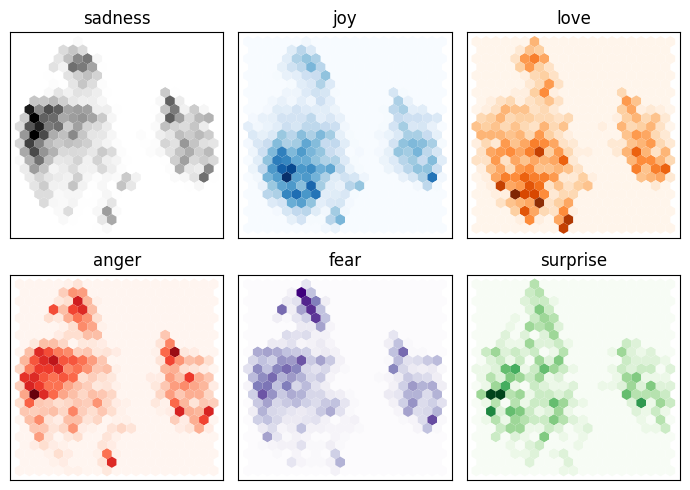

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize = 20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()




*   확실한 패턴이 보임.
*   부정적인 감정은 조금의 차이가 있지만 차지한 영역이 모두 비슷함.
*   joy, love는 부정적인 감정과 분리가 잘되어 있고 비슷한 영역을 차지함.
*   surprose는 영역 전체에 골고루 분포되어 있음.
*   모델이 감정차이를 분리하지 않고 단어를 추측해 암묵적으로 감정을 학습했음을 알 수 있음.

### 간단한 분류 모델 훈련하기

In [50]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [51]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

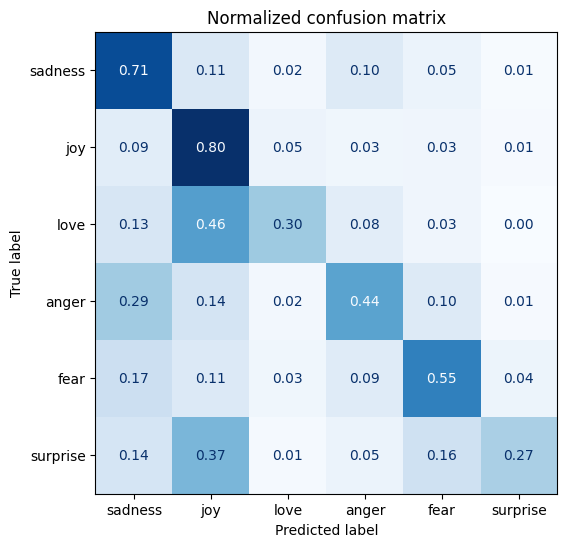

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize = (6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)



*   anger, fear는 sadness와 가장 많이 혼동됨
*   love, surprise는 joy로 혼동됨



## 트랜스포머 미세튜닝

In [53]:
# 모델 로드
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.
         from_pretrained(model_ckpt, num_labels = num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# 성공 지표 정하기
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1) # 각 행에 대해 가장 큰 값을 가지는 열의 인덱스를 찾는 것 -> 가장 높은 확률을 가진 클래스의 인덱스를 예측
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy":acc, "f1":f1}

In [66]:
from huggingface_hub import notebook_login
notebook_login()

In [56]:
# ! pip install transformers

In [57]:
# ! pip install accelerate -U

In [58]:
# ! pip install transformers[torch]

In [59]:
!pip show accelerate

Name: accelerate
Version: 0.29.3
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [60]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps=logging_steps,
                                  push_to_hub = True,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [67]:
from transformers import Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics = compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.805900,0.320948,0.901500,0.900835
2,0.245300,0.220404,0.923500,0.923551


TrainOutput(global_step=500, training_loss=0.5256080627441406, metrics={'train_runtime': 237.6028, 'train_samples_per_second': 134.679, 'train_steps_per_second': 2.104, 'total_flos': 720342861696000.0, 'train_loss': 0.5256080627441406, 'epoch': 2.0})

In [69]:
pred_output = trainer.predict(emotions_encoded["validation"])

In [72]:
pred_output.metrics

{'test_loss': 0.220404252409935,
 'test_accuracy': 0.9235,
 'test_f1': 0.9235514894943672,
 'test_runtime': 5.1291,
 'test_samples_per_second': 389.935,
 'test_steps_per_second': 6.239}

In [73]:
y_preds = np.argmax(pred_output.predictions, axis=1)

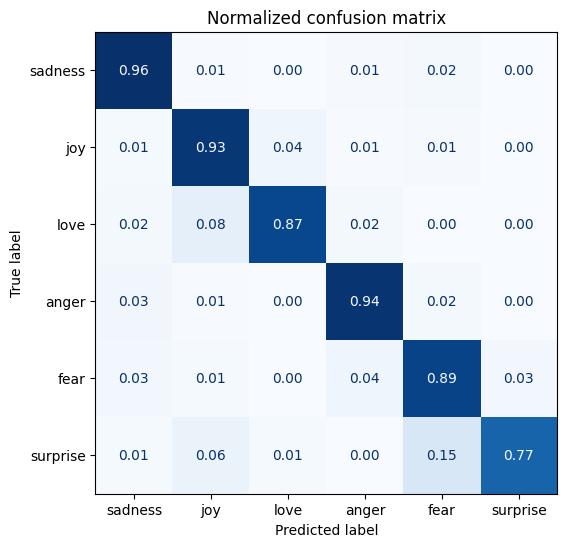

In [75]:
plot_confusion_matrix(y_preds, y_valid, labels)

- 전반적으로 성능이 우수함.

## 오류분석

In [76]:
from torch.nn.functional import cross_entropy
def forwrad_pass_with_label(batch):
  # 모든 입력 텐서를 모델과 같은 장치로 이동
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [78]:
# 데이터셋을 파이토치 텐서로 변환
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forwrad_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [83]:
# 텍스트,손실,예측 레이블,정답 DataFrame
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_labels"] = (df_test["predicted_label"].
                               apply(label_int2str))

In [84]:
# 모델의 가장 나쁜 예측을 확인
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss,predicted_labels
1950,i as representative of everything thats wrong ...,surprise,0,5.475485,sadness
1500,i guess we would naturally feel a sense of lon...,anger,0,5.408462,sadness
1870,i guess i feel betrayed because i admired him ...,joy,0,5.177741,sadness
1274,i am going to several holiday parties and i ca...,joy,0,5.166399,sadness
765,i feel super awkward and out of place right now,joy,0,5.137252,sadness
1801,i feel that he was being overshadowed by the s...,love,0,5.022885,sadness
1963,i called myself pro life and voted for perry w...,joy,0,5.009725,sadness
1509,i guess this is a memoir so it feels like that...,joy,4,4.980546,fear
177,im sure much of the advantage is psychological...,sadness,1,4.945297,joy
465,i would eventually go in to these stores but i...,joy,4,4.894782,fear


- joy 레이블이 잘못됨.

In [85]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss,predicted_labels
1861,im tired of feeling lethargic hating to work o...,sadness,0,0.015223,sadness
1466,i feel so ungrateful to be wishing this pregna...,sadness,0,0.015440,sadness
1601,i feel so ungrateful when thinking saying thes...,sadness,0,0.015582,sadness
1452,i always feel guilty and come to one conclusio...,sadness,0,0.015807,sadness
1531,i forgive stanley hes not so quick to forgive ...,sadness,0,0.015875,sadness
244,im kinda relieve but at the same time i feel d...,sadness,0,0.015880,sadness
1656,im feeling very jaded and uncertain about love...,sadness,0,0.015888,sadness
1303,i feel pathetic and uninspired,sadness,0,0.015987,sadness
1965,i started feeling pathetic and ashamed,sadness,0,0.015999,sadness
133,i and feel quite ungrateful for it but i m loo...,sadness,0,0.016068,sadness


- sadness를 가장 잘 예측함
- 위의 정보를 합쳐서 데이터셋을 개선하면 더 좋은 성능을 낼 수 있음

In [86]:
trainer.push_to_hub(commit_message="Training completed")

CommitInfo(commit_url='https://huggingface.co/Eunssong/distilbert-base-uncased-finetuned-emotion/commit/2be1f928197f85a8eaad5590d8d060accb21c80e', commit_message='Training completed', commit_description='', oid='2be1f928197f85a8eaad5590d8d060accb21c80e', pr_url=None, pr_revision=None, pr_num=None)

In [87]:
# 파이프라인 이용
from transformers import pipeline

model_id = "Eunssong/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [88]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


## 예측 확률 시각화

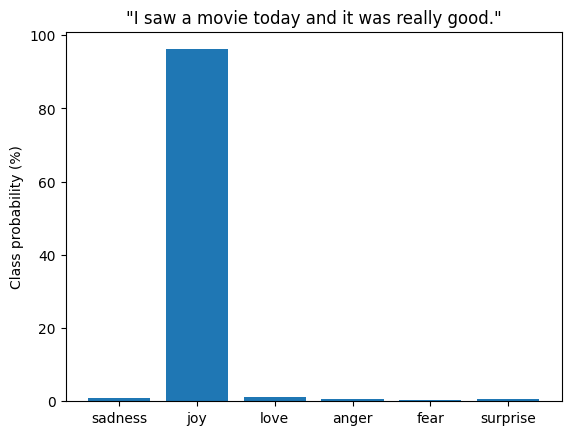

In [89]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df['score'])
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()